In [1]:
using DMRJtensor
include("su2_tools.jl");


In [5]:
# setup system with isotropic J
spinmag = 1.0;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag)
Ns = 16 # number of sites
# J_p array, e.g. H = sum_p[ -J_p (S*S)^p ]
J_arr = [0.0, 2.0]; # spin nematic?
H_onesite = H_SU2(spinmag, J_arr) # make the onsite term
H_mpo = makeMPO(H_onesite,size(Id,1),Ns); # make the MPO!
psi0 = makePsi0(spinmag,Ns);
psi = copy(psi0)
println(psi[1])

printing regular tensor of type: tens{Complex{Float64}}
size = (1, 3, 1)
T = Complex{Float64}[0.05250753897588445 + 0.5662749967121954im, 0.08461914007849591 + 0.20462392084205128im, 0.08419428253524419 + 0.6805277924740087im]



In [9]:
# DMRG sweeps, with refinement 

nsweeps_m10 = 20
nsweeps_m40 = 10
nsweeps_m80 = 5

for i in 1:nsweeps_m10
    @time dmrg(psi, H_mpo, maxm = 10, cutoff = 1E-4)
end
println("coarse run completed")
for i in 1:nsweeps_m40
    @time dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-8)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

  9.926484 seconds (25.06 M allocations: 1.340 GiB, 6.30% gc time)
  0.049737 seconds (40.91 k allocations: 30.385 MiB, 15.80% gc time)
  0.040675 seconds (40.91 k allocations: 30.385 MiB)
  0.097350 seconds (40.91 k allocations: 30.385 MiB, 5.32% gc time)
  0.065536 seconds (40.91 k allocations: 30.385 MiB, 5.60% gc time)
  0.080686 seconds (40.91 k allocations: 30.385 MiB)
  0.043195 seconds (40.91 k allocations: 30.385 MiB, 8.01% gc time)
  0.084568 seconds (40.83 k allocations: 30.184 MiB, 4.11% gc time)
  0.041832 seconds (40.50 k allocations: 29.417 MiB, 8.30% gc time)
  0.076067 seconds (40.45 k allocations: 29.275 MiB)
  0.041706 seconds (40.45 k allocations: 29.275 MiB, 8.51% gc time)
  0.068827 seconds (40.45 k allocations: 29.275 MiB, 5.18% gc time)
  0.056778 seconds (40.45 k allocations: 29.275 MiB)
  0.079022 seconds (40.45 k allocations: 29.275 MiB, 4.48% gc time)
  0.042330 seconds (40.45 k allocations: 29.275 MiB, 8.24% gc time)
  0.068691 seconds (40.45 k allocations:

In [10]:
# Evaluate energy and average net magnetization

H_tot = expect(psi,H_mpo)

Sz_onesite = [Id O
              Sz Id];
Sz_mpo = makeMPO(Sz_onesite,size(Id,1),Ns); # make the MPO!
Sx_onesite = [Id O
              Sx Id];
Sx_mpo = makeMPO(Sx_onesite,size(Id,1),Ns); # make the MPO!
Sy_onesite = [Id O
              Sy Id];
Sy_mpo = makeMPO(Sy_onesite,size(Id,1),Ns); # make the MPO!

Sx_tot = expect(psi,Sx_mpo)
Sy_tot = expect(psi,Sy_mpo)
Sz_tot = expect(psi,Sz_mpo)

println("H_tot: ", real(H_tot))
println("Avg|M|: ",norm([Sx_tot,Sy_tot,Sz_tot])/Ns)

H_tot: 30.00000001696637
Avg|M|: 0.7836555915974285


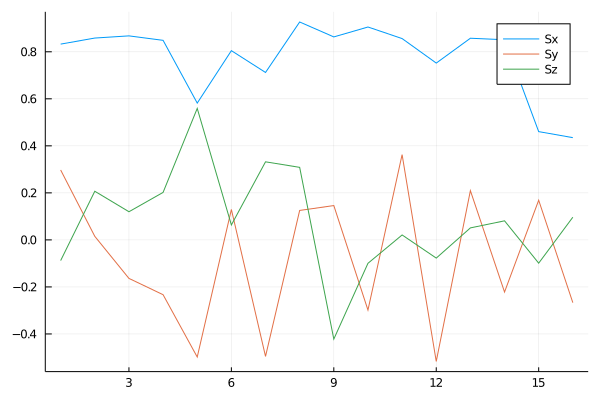

In [11]:
# Evaluate and plot the site-dependent magnetization
S_vals = zeros(ComplexF64,Ns,3)
S_ops = [Sx, Sy, Sz]

S0 = [Id O 
      O Id]
S0_mpo = Array{Array{ComplexF64,2},1}(undef,Ns)

for site = 1:Ns
   S0_mpo[site] = S0
end

for site = 1:Ns
    for op_idx = 1:3
        Sop_here = copy(S0_mpo)
        Sop_here[site] = [Id            O
                          S_ops[op_idx] Id]
        mpo_h = makeMPO(Sop_here,size(Id,1),Ns)
        S_vals[site,op_idx] = expect(psi,mpo_h)
    end
end

using Plots
plot(broadcast(real,S_vals[:,1]),label="Sx")
plot!(broadcast(real,S_vals[:,2]),label="Sy")
plot!(broadcast(real,S_vals[:,3]),label="Sz")